Imports e Configuração

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import sys
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.storage import CloudStorage

sns.set_theme(style="whitegrid")

Carga de Dados

In [9]:
cs = CloudStorage()
df = cs.ler_csv('carros_dados_limpos.csv')

df = df.dropna()
df.head()

📂 Lendo do disco local: carros_dados_limpos.csv...


,Título,Descrição,Preço,Local,Ano,KM Rodado,Cidade,Estado,Transmissão
0,Chevrolet Onix,Onix 1.0 Joy SPE/4 manual,52900.0,"Belo Horizonte, MG",2019,72000,Belo Horizonte,MG,Manual
1,Honda CR-V,CR-V 2.0 16V 4X4 EXL (aut) automático,89000.0,"Vassouras, RJ",2012,80000,Vassouras,RJ,Automático
2,BMW Série 3,320i ActiveFlex automático,114900.0,"Sinop, MT",2015,10,Sinop,MT,Automático
3,Hyundai HB20,HB20 1.6 Comfort Plus (Aut) automático,70900.0,"Taubaté, SP",2018,56000,Taubaté,SP,Automático
4,Chevrolet Tracker,Tracker 1.2 Turbo Premier (Aut) automático,108900.0,"Belo Horizonte, MG",2020,40000,Belo Horizonte,MG,Automático


Engenharia de Features

In [10]:

def extrair_motor(texto):
    padrao = r'(\d\.\d)' 
    match = re.search(padrao, str(texto))
    if match:
        return float(match.group(1))
    return np.nan

df['Motor'] = df['Descrição'].apply(extrair_motor)

df['Motor'] = df['Motor'].fillna(df['Motor'].mode()[0])

ano_atual = 2025
df['Idade'] = ano_atual - df['Ano']

df['Km_por_Ano'] = df['KM Rodado'] / (df['Idade'] + 1)

print("Novas features criadas:")
display(df[['Descrição', 'Motor', 'Ano', 'Idade', 'Km_por_Ano']].head())

Novas features criadas:


,Descrição,Motor,Ano,Idade,Km_por_Ano
0,Onix 1.0 Joy SPE/4 manual,1.0,2019,6,10285.714286
1,CR-V 2.0 16V 4X4 EXL (aut) automático,2.0,2012,13,5714.285714
2,320i ActiveFlex automático,1.0,2015,10,0.909091
3,HB20 1.6 Comfort Plus (Aut) automático,1.6,2018,7,7000.000000
4,Tracker 1.2 Turbo Premier (Aut) automático,1.2,2020,5,6666.666667


Pré-processamento

In [11]:
le_marca = LabelEncoder()
le_cambio = LabelEncoder()
le_estado = LabelEncoder()

df['Marca_Cod'] = le_marca.fit_transform(df['Título'].apply(lambda x: x.split()[0]))
df['Cambio_Cod'] = le_cambio.fit_transform(df['Transmissão'])
df['Estado_Cod'] = le_estado.fit_transform(df['Estado'])

features = ['Marca_Cod', 'Idade', 'KM Rodado', 'Motor', 'Cambio_Cod', 'Estado_Cod', 'Km_por_Ano']
target = 'Preço'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

Treino: (7888, 7), Teste: (1972, 7)


Clusterização

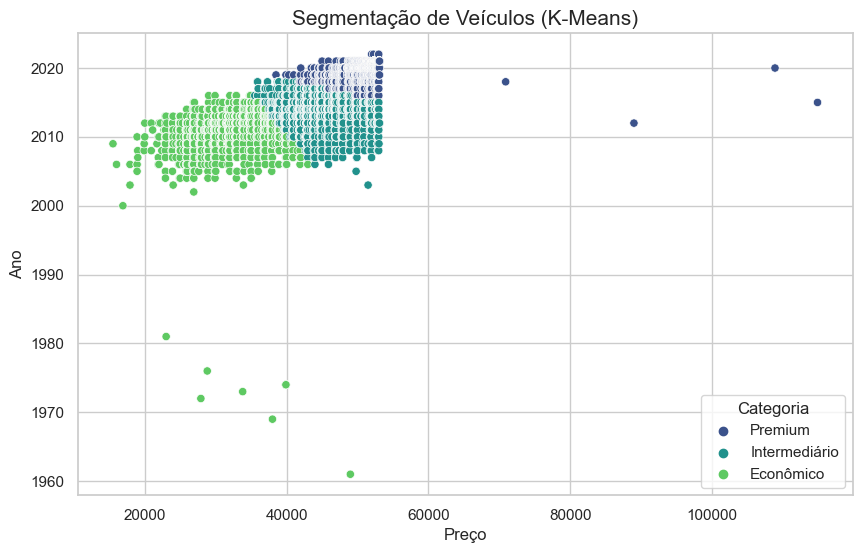

In [12]:
X_cluster = df[['Preço', 'Ano']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_map = df.groupby('Cluster')['Preço'].mean().sort_values().index
mapa_nomes = {cluster_map[0]: 'Econômico', cluster_map[1]: 'Intermediário', cluster_map[2]: 'Premium'}
df['Categoria'] = df['Cluster'].map(mapa_nomes)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Preço', y='Ano', hue='Categoria', palette='viridis')
plt.title('Segmentação de Veículos (K-Means)', fontsize=15)
plt.show()

Treinamento

In [13]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

Avaliação do Modelo

In [17]:
y_pred = rf_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"--- Performance do Random Forest ---")
print(f"R² Score: {r2:.4f}")
print(f"Erro Médio (RMSE): R$ {rmse:.2f}")
print(f"Erro Absoluto (MAE): R$ {mae:.2f}")

--- Performance do Random Forest ---
R² Score: 0.7716
Erro Médio (RMSE): R$ 3800.67
Erro Absoluto (MAE): R$ 2659.78


Gráfico Real vs Previsto

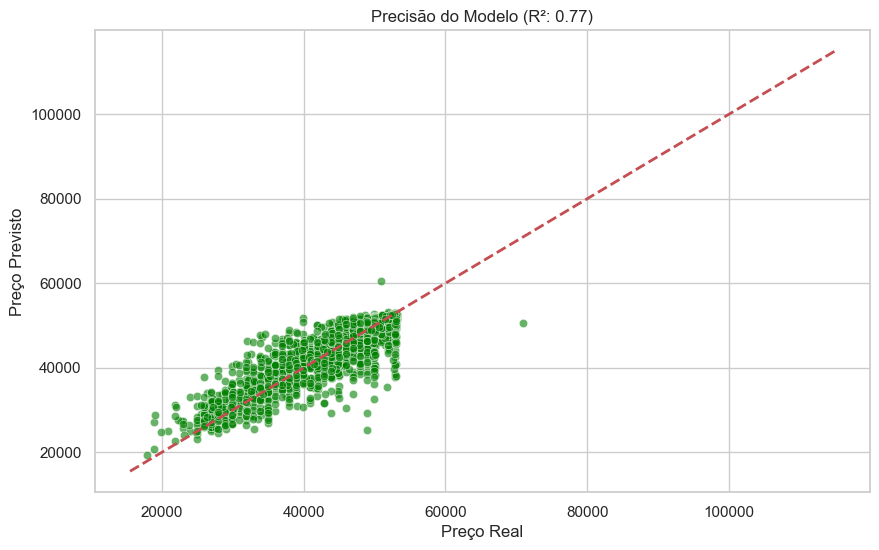

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) 
plt.xlabel('Preço Real')
plt.ylabel('Preço Previsto')
plt.title(f'Precisão do Modelo (R²: {r2:.2f})')
plt.show()

Importância de cada Feature

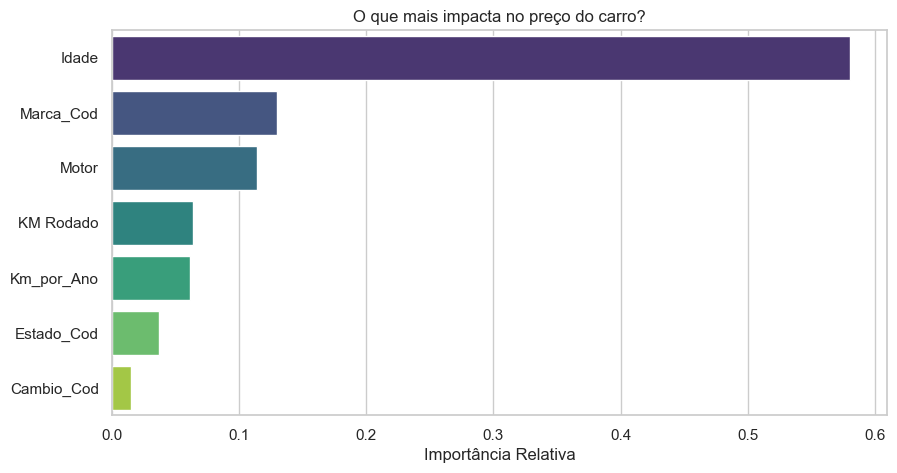

In [16]:
importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=importances.index, palette='viridis')
plt.title('O que mais impacta no preço do carro?')
plt.xlabel('Importância Relativa')
plt.show()